In [357]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [374]:
def affichage(dic):
    #fonction qui permet d'afficher une grille d'images contenues dans un dictionnaire
    for i, (title, img) in enumerate(dic.items()):
        if i % 2 == 0:
            plt.figure(figsize=(40, 40))
        plt.subplot(1, 2, i % 2 + 1)
        plt.imshow(img, cmap='gray')
        plt.title(title, fontsize=40)
        plt.axis('off')
        if i % 2 == 1 or i == len(dic) - 1:
            plt.tight_layout()
            plt.show()

In [370]:
def cosine(a,b):
    #algorithme de comparaison cosine de deux vecteurs numpy de meme dimension
    #plus la valeur est proche de 1, plus les vecteurs sont proches
    return dot(a,b)/(norm(a)*norm(b))

In [ ]:
def cos_resize(elem):
    #permet de mettre deux vecteurs de dimensions differentes à la meme dimension et de les normaliser
    #pour ensuite les comparer via la similarité cosine

    _, thresh = cv2.threshold(elem, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    cropped = thresh.astype(np.float32) / 255.
    cropped =  (elem - np.mean(elem)) / (np.std(elem) + 1e-6)
    cropped = cv2.resize(cropped, (224, 24), interpolation=cv2.INTER_AREA)
    return cropped

In [ ]:
def image_cut(img): #récupère etiquette de texte original la plus fine a partir d'une etiquette grossière, 
    #l'image doit etre donnée deja en noir et blanc
    
    #étape de prétraitement de l'image, déjà en noir en blanc
    _, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(binary, kernel, iterations=1)

    #suppression lignes totalement blanches
    masque_lignes = ~np.all(dilated == 255, axis=1)
    lignes_texte = np.where(masque_lignes)[0]

    if len(lignes_texte) == 0: #si l'image est déjà blanche on la renvoie
        return img 

    img_lignes = dilated[lignes_texte[0]:lignes_texte[-1]+1, :]

    #suppression des colonnes totalement blanches
    masque_colonnes = ~np.all(img_lignes == 255, axis=0)
    colonnes_texte = np.where(masque_colonnes)[0]

    a = lignes_texte[0]
    a_bis = lignes_texte[-1] + 1
    b = colonnes_texte[0]
    b_bis = colonnes_texte[-1] + 1

    imgfinale = img[a: a_bis, b : b_bis] #memes coord que le rectangle trouvé mais sur image originale

    return imgfinale


In [386]:
#récupération de données servant à établir les étiquettes de versio_antiqua et vulgata_nova pour l'identification des titres

im0064_or = cv2.imread('images/image-0064.png')
im0971_or = cv2.imread('images/image-0971.png')
im0088_or = cv2.imread('images/image-0088.png')
im0851_or = cv2.imread('images/image-0851.png')
im0479_or = cv2.imread('images/image-0479.png')

im0064 = cv2.cvtColor(image_original, cv2.COLOR_BGR2GRAY)
im0971 = cv2.cvtColor(im0971_or, cv2.COLOR_BGR2GRAY)
im0088 = cv2.cvtColor(im0088_or, cv2.COLOR_BGR2GRAY)
im0851 = cv2.cvtColor(im0851_or, cv2.COLOR_BGR2GRAY)
im0479 = cv2.cvtColor(im0479_or, cv2.COLOR_BGR2GRAY)

im0064_ant = im0064[230:260, 740:1040] #0064
im0088_ant = im0088[245:280, 770:1025] #0088
im0971_ant = im0971[220:245, 400:682] #0971
im0851_ant = im0851[230:265, 440:750] #0851
im0479_ant = im0479[210:240, 340:700] # 0479

#etiquettes grossières sur image originale pour versio_antiqua
li_antiqua_before = [im0064_ant, im0088_ant, im0971_ant, im0851_ant, im0479_ant]


im0064_vul = im0064[230:260, 270:550]
im0088_vul = im0088[240:280, 300:550]
im0851_vul = im0851[240:270, 950:1200]
im0479_vul = im0479[210:235, 900:1150]
im0971_vul = im0971[220:250, 910:1150]

#etiquettes grossières sur image originale pour vulgata_nova
li_vulgata_before = [im0064_vul, im0088_vul, im0851_vul, im0479_vul, im0971_vul]


#obtention des étiquettes fines sur versio_antiqua et vulgata_nova
li_antiqua = [image_cut(li_antiqua_before[k]) for k in range(len(li_antiqua_before))]
li_vulgata = [image_cut(li_vulgata_original[k]) for k in range(len(li_vulgata_original))]



In [387]:
#liste des comparaisons cosine des etiquettes versio_antiqua entre elles pour verifier leur correspondance
li_antiqua_cosine = [] 

for i in range(len(li_antiqua)-1):
    for j in range(i+1, len(li_antiqua)):
        li_antiqua_cosine.append(cosine(cos_resize(li_antiqua[i]).flatten(), cos_resize(li_antiqua[j]).flatten()))


#liste des comparaisons cosine des etiquettes vulgata_nova entre elles pour verifier leur correspondance
li_vulgata_cosine = []

for i in range(len(li_vulgata)-1):
    for j in range(i+1, len(li_vulgata)):
        li_vulgata_cosine.append(cosine(cos_resize(li_vulgata[i]).flatten(), cos_resize(li_antiqua[j]).flatten()))


#liste des comparaisons cosine des etiquettes vulgata_nova et versio_antiqua entre elles pour verifier qu'elles ne correspondent pas
vulgata_antiqua = []
for elem1 in li_antiqua:
    for elem2 in li_vulgata:
        vulgata_antiqua.append(cosine(cos_resize(elem1).flatten(), cos_resize(elem2).flatten()))


#on obtient une reconnaissance satisfaisante des etiquettes versio antiqua entre elles, celle entre les vulgata_nova
#n'est pas très concluante mais une etiquette versio_antiqua n'est jamais assimilée à une etiquette vulgata_antiqua
#ce qui est le plus important dans notre cas

In [389]:
def test_antiqua_vulgata(img): 
    #donne appartenance de l'étiquette à antiqua ou vulgata pour une image deja en noir et blanc
    test = image_cut(img)
    test = cos_resize(test)
    
    cosine_test_antiqua = []
    cosine_test_vulgata = []
    for i in range(len(li_antiqua)):
        cosine_test_antiqua.append(cosine(test.flatten(), cos_resize(li_antiqua[i]).flatten()))
        cosine_test_vulgata.append(cosine(test.flatten(), cos_resize(li_vulgata[i]).flatten()))

    max_antiqua = np.max(cosine_test_antiqua)
    max_vulgata = np.max(cosine_test_vulgata)

    if max_antiqua > max_vulgata and max_antiqua>0.40:
        return "versio antiqua"

    elif max_vulgata > max_antiqua and max_vulgata>0.40:
        return "vulgata nova"

    return "autre"


In [548]:
im0184_or = cv2.imread('images/image-0184.png')
im0184 = cv2.cvtColor(im0184_or, cv2.COLOR_BGR2GRAY)

im0185_or = cv2.imread('images/image-0185.png')
im0185 = cv2.cvtColor(im0185_or, cv2.COLOR_BGR2GRAY)

im0183_or = cv2.imread('images/image-0183.png')
im0183 = cv2.cvtColor(im0183_or, cv2.COLOR_BGR2GRAY)


im0186_or = cv2.imread('images/image-0186.png')
im0186 = cv2.cvtColor(im0186_or, cv2.COLOR_BGR2GRAY)

im0189_or = cv2.imread('images/image-0189.png')
im0189 = cv2.cvtColor(im0189_or, cv2.COLOR_BGR2GRAY)

im0192_or = cv2.imread('images/image-0192.png')
im0192 = cv2.cvtColor(im0192_or, cv2.COLOR_BGR2GRAY)

im0195_or = cv2.imread('images/image-0195.png')
im0195 = cv2.cvtColor(im0195_or, cv2.COLOR_BGR2GRAY)

im0197_or = cv2.imread('images/image-0197.png')
im0197 = cv2.cvtColor(im0197_or, cv2.COLOR_BGR2GRAY)

im0200_or = cv2.imread('images/image-0200.png')
im0200 = cv2.cvtColor(im0200_or, cv2.COLOR_BGR2GRAY)

im0205_or = cv2.imread('images/image-0205.png')
im0205 = cv2.cvtColor(im0205_or, cv2.COLOR_BGR2GRAY)

im0208_or = cv2.imread('images/image-0208.png')
im0208 = cv2.cvtColor(im0208_or, cv2.COLOR_BGR2GRAY)

im1039_or = cv2.imread('images/image-1039.png')
im1039 = cv2.cvtColor(im1039_or, cv2.COLOR_BGR2GRAY)

im0788_or = cv2.imread('images/image-0788.png')
im0788 = cv2.cvtColor(im0788_or, cv2.COLOR_BGR2GRAY)

im0788_or = cv2.imread('images/image-0788.png')
im0788 = cv2.cvtColor(im0788_or, cv2.COLOR_BGR2GRAY)

im1038_or = cv2.imread('images/image-1038.png')
im1038 = cv2.cvtColor(im1038_or, cv2.COLOR_BGR2GRAY)

im1039_or = cv2.imread('images/image-1039.png')
im1039 = cv2.cvtColor(im1039_or, cv2.COLOR_BGR2GRAY)

im1040_or = cv2.imread('images/image-1040.png')
im1040 = cv2.cvtColor(im1040_or, cv2.COLOR_BGR2GRAY)

im1042_or = cv2.imread('images/image-1042.png')
im1042 = cv2.cvtColor(im1042_or, cv2.COLOR_BGR2GRAY)

im1043_or = cv2.imread('images/image-1043.png')
im1043 = cv2.cvtColor(im1043_or, cv2.COLOR_BGR2GRAY)

im1044_or = cv2.imread('images/image-1044.png')
im1044 = cv2.cvtColor(im1044_or, cv2.COLOR_BGR2GRAY)

im1045_or = cv2.imread('images/image-1045.png')
im1045 = cv2.cvtColor(im1045_or, cv2.COLOR_BGR2GRAY)


im1047_or = cv2.imread('images/image-1047.png')
im1047 = cv2.cvtColor(im1047_or, cv2.COLOR_BGR2GRAY)

im1003_or = cv2.imread('images/image-1003.png')
im1003 = cv2.cvtColor(im1003_or, cv2.COLOR_BGR2GRAY)





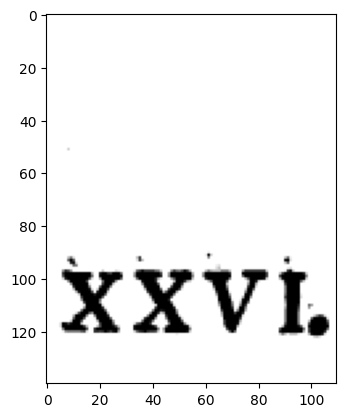

In [543]:
plt.imshow(im0208[100:240, 900:1010], cmap = 'gray')

In [549]:
#etablissemnt d'étiquettes pour les numeros de chapitres
#ch23
ch23 = [cos_resize(image_cut(im0184[150:260, 880:1050]))]
ch23.append(cos_resize(image_cut(im0185[150:240, 1030:1200])))

imtest23 = im0183[200:250, 1030:1200]
imtest23 = image_cut(imtest23)
imtest23 = cos_resize(imtest23)
ch23.append(imtest23)

#ch24
ch24 = []

imtest24 = im0186[180:260, 880:1000]
imtest24 = image_cut(imtest24)
imtest24 = cos_resize(imtest24)
ch24.append(imtest24)

im24 = im0189[150:240, 1050:1200]
im24 = cos_resize(image_cut(im24))
ch24.append(im24)

im24 = im0192[150:240, 880:1050]
im24 = cos_resize(image_cut(im24))
ch24.append(im24)

#ch25
ch25 = []
im25 = cos_resize(image_cut(im0195[150:240, 1030:1200]))
ch25.append(im25)

im25 = cos_resize(image_cut(im0197[150:240, 1050:1200]))
ch25.append(im25)

im25 = cos_resize(image_cut(im0200[100:250, 900:1000]))
ch25.append(im25)

#ch26
ch26 = []
im26 = cos_resize(image_cut(im0208[100:240, 900:1010]))
ch26.append(im26)


print(cosine(ch25[0].flatten(), ch23[1].flatten()))

0.16039256386376508


In [552]:
def compatibilite_cosine(img, li):
    comp = [cosine(img.flatten(),li[k].flatten()) for k in range(len(li))]
    return np.max(comp)

def test_chapitre(img):
    compatibilite = []
    for i in range(chapter_max):
        compatibilite.append(compatibilite_cosine(img, f"ch{i}"))

    elemax = compatibilite.index(np.max(compatibilite))

    if elemax>0.40:
        return compatibilite.index(np.max(compatibilite))
    return "autre"
        
